In [1]:
import rawio 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cdms
from ROOT import *
from os.path         import exists
from cats.cdataframe import CDataFrame 
#import cats
from supercuts import ledOn_old
if cdms.get_global_version() == 'V05-02-00':
    from ROOT.gInterpreter import ProcessLine
    ProcessLine("using namespace supercuts;")
from CDMSDataCatalog import CDMSDataCatalog

from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.stats import norm
from scipy import signal

Welcome to JupyROOT 6.28/10


In [2]:
# double exponential function to mimic the pulse
samplerate=625000
def two_exp_fit(x, amp1, t1, t2, baseline, pretrigger):
    y = np.where(x <= pretrigger, baseline, -(amp1 * np.exp(-(x-pretrigger) / t1 /samplerate) - amp1 * np.exp(-(x-pretrigger) / t2/samplerate)) + baseline)
    return y

# triple exponential function to mimic the pulse
def three_exp_fit(x, amp1, amp2, t1, t2, t3, baseline, pretrigger):
    y = np.where(x <= pretrigger, baseline, -((amp1+amp2) * np.exp(-(x-pretrigger) / t1 /samplerate) - amp1 * np.exp(-(x-pretrigger) / t2/samplerate) - amp2 * np.exp(-(x-pretrigger) / t3/samplerate)) + baseline)
    return y

# quadraple exponential function to mimic the pulse
def four_exp_fit(x, amp1, amp2, amp3, t1, t2, t3, t4, baseline, pretrigger):
    y = np.where(x <= pretrigger, baseline, -((amp1+amp2+amp3) * np.exp(-(x-pretrigger) / t1 /samplerate) - amp1 * np.exp(-(x-pretrigger) / t2/samplerate) - amp2 * np.exp(-(x-pretrigger) / t3/samplerate) - amp3 * np.exp(-(x-pretrigger) / t4/samplerate)) + baseline)
    return y


In [3]:
# merge_Test_51240909_000000.root

#series_list = ['51240909_000000']

#filepath = CDMSDataCatalog().findData(
#    Facility    = "NoLab",
#    ProdTag     = "HV100mm_DMCER_DC3Prod-V2.1.0",
#    dofetch     = True
#)
    #nFridgeRun  = 37,
    #Series      = '51240909_000000',
    #nMergeLevel = 1,

#print (filepath)
#filepath = [x.filePath for x in filepath]

In [4]:
filepath = "/fs/ddn/sdf/group/supercdms/data/CDMS/NoLab/HV100mm_DMCER_DC3Prod-V2.1.0/Simulated/Processed/CDMSBats-v6.5.1_P0.3.3/Submerged/merge_Test_51240909_000000.root"

In [5]:
# Figure out data directory
rootDir_s3df = "/fs/ddn/sdf/group/supercdms"
rootDir_drac = "/project/rrg-mdiamond"
relDir       = "/data/CDMS/CUTE/R37/Processed/Prompt/Prompt_V04-15_P0.2.1/Submerged"

if   exists(rootDir_s3df): dataDir = rootDir_s3df + relDir
elif exists(rootDir_drac): dataDir = rootDir_drac + relDir
else: raise Exception("Couldn't find data directory?  Are you not on S3DF or ComputeCanada?")

In [6]:
def get_df(dataDir, series):
    """
    Get df from a series. No cuts applied(?)

    Parameters:
    dataDir: directory path
    series: series name

    Returns:
    data frame

    """
    #filepath = f"{dataDir}/Prompt_V04-15_P0.2.1_{series}.root"

    #filepath = "/sdf/scratch/users/y/yanliu/data/cute/public/Ge_public_plot_20240127.root"
    filepath = "/fs/ddn/sdf/group/supercdms/data/CDMS/NoLab/HV100mm_DMCER_DC3Prod-V2.1.0/Simulated/Processed/CDMSBats-v6.5.1_P0.3.3/Submerged/merge_Test_51240909_000000.root"
    #filepath = "~/Ge_public_plot_20240127.root"

    
    print (filepath)

    # One CDataframe per detector, identified by detector number (1-6)
    dfs_orig = {
        det: CDataFrame(f"rqDir/zip{det}", filepath, [f"{filepath}:rqDir/eventTree"])
        for det in range(7, 8)
    }

    return dfs_orig

In [7]:
det = 7
dets = [7]
series = "random"
df = get_df(dataDir, series)

/fs/ddn/sdf/group/supercdms/data/CDMS/NoLab/HV100mm_DMCER_DC3Prod-V2.1.0/Simulated/Processed/CDMSBats-v6.5.1_P0.3.3/Submerged/merge_Test_51240909_000000.root


In [8]:
df

{7: <cppyy.gbl.ROOT.RDataFrame object at 0x55f9234ad170>}

In [9]:
#basic cuts

df[det] = df[det].Filters(["TriggerType==1"]) ############# Physic trigger cut!!

In [10]:
cuts = {7:["PTOFamps>0.5e-6","PTOFamps<5e-6"]}

#cuts = {7:["PTOFamps>0.5e-6"]}

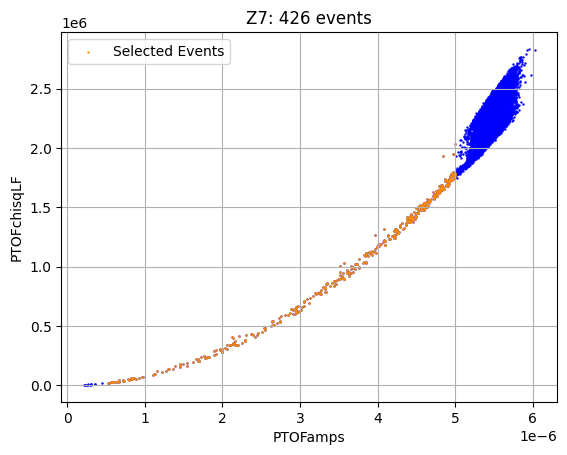

In [11]:
data = df[det].AsNumpy(columns=['PTOFamps', 'PTOFchisqLF'])
plt.scatter(data['PTOFamps'], data['PTOFchisqLF'], s=0.5, color='b')

data_cut = df[det].Filters(cuts[det]).AsNumpy(columns=['PTOFamps', 'PTOFchisqLF'])
plt.scatter(data_cut['PTOFamps'], data_cut['PTOFchisqLF'], s=0.5, color='darkorange', label="Selected Events")
plt.xlabel("PTOFamps")
plt.ylabel("PTOFchisqLF")
#plt.xlim(1e-7,1e-5)
#plt.xscale("log")
#plt.yscale("log")
plt.title(f"Z{det}: {len(data_cut['PTOFamps'])} events")
plt.legend()
plt.grid()

In [12]:
#apply cuts
df[det] = df[det].Filters(cuts[det])

## 1x1 Templates

### Extract Raw Pulses

In [16]:
chan_names = ['PAS1', 'PBS1', 'PCS1', 'PDS1', 'PES1', 'PFS1','PAS2', 'PBS2', 'PCS2', 'PDS2', 'PES2', 'PFS2']
raw_path = '/fs/ddn/sdf/group/supercdms/data/CDMS/NoLab/HV100mm_DMCER_DC3Prod-V2.1.0/Simulated/DAQSim/DAQSim-v6.4.1'
raw_events = {7:{}}
events = {7:{}}

try:
    myreader = rawio.RawDataReader(filepath=raw_path, series="51240909_000000")
except ValueError:
    print(f"ERROR- No midas raw data files found for {series_list[index]}")
    

INFO: Found 125 midas raw data files


Store the baseline and delay values for each event in a dictionary while pulling out the raw pulses

In [13]:
import pickle 
chan_names = ['PAS1', 'PBS1', 'PCS1', 'PDS1', 'PES1', 'PFS1','PAS2', 'PBS2', 'PCS2', 'PDS2', 'PES2', 'PFS2']
with open('cut_events1.pkl', 'rb') as file: 
    events = pickle.load(file)
with open('cut_raw_events1.pkl', 'rb') as file: 
    raw_events = pickle.load(file)

In [14]:
delay = {}
baselines = {}
baselines[det] = {}
delay[det] = {}

baselines[det]["51240909_000000"] = {}
delay[det]["51240909_000000"] = {}
series_events = df[det].AsNumpy(columns=["EventNumber"])["EventNumber"]

for chan in chan_names:
    print (det, "51240909_000000", chan)
    chan_cols = df[det].AsNumpy(columns=[chan+"OFdelay",chan+"bs"])
    delay[det]["51240909_000000"][chan] = {series_events[i]: chan_cols[chan+"OFdelay"][i] for i in range(len(series_events))}
    baselines[det]["51240909_000000"][chan] = {series_events[i]: chan_cols[chan+"bs"][i] for i in range(len(series_events))}


7 51240909_000000 PAS1
7 51240909_000000 PBS1
7 51240909_000000 PCS1
7 51240909_000000 PDS1
7 51240909_000000 PES1
7 51240909_000000 PFS1
7 51240909_000000 PAS2
7 51240909_000000 PBS2
7 51240909_000000 PCS2
7 51240909_000000 PDS2
7 51240909_000000 PES2
7 51240909_000000 PFS2


In [15]:
#print (delay[7]["51240909_000000"])

In [16]:
import pickle 
chan_names = ['PAS1', 'PBS1', 'PCS1', 'PDS1', 'PES1', 'PFS1','PAS2', 'PBS2', 'PCS2', 'PDS2', 'PES2', 'PFS2']
with open('cut_bs1.pkl', 'rb') as file: 
    baselines = pickle.load(file)
with open('cut_delay1.pkl', 'rb') as file: 
    delay = pickle.load(file)

### Get the Average Pulse Aligned and Normalized

PAS1 done
PBS1 done
PCS1 done
PDS1 done
PES1 done
PFS1 done
PAS2 done
PBS2 done
PCS2 done
PDS2 done
PES2 done
PFS2 done


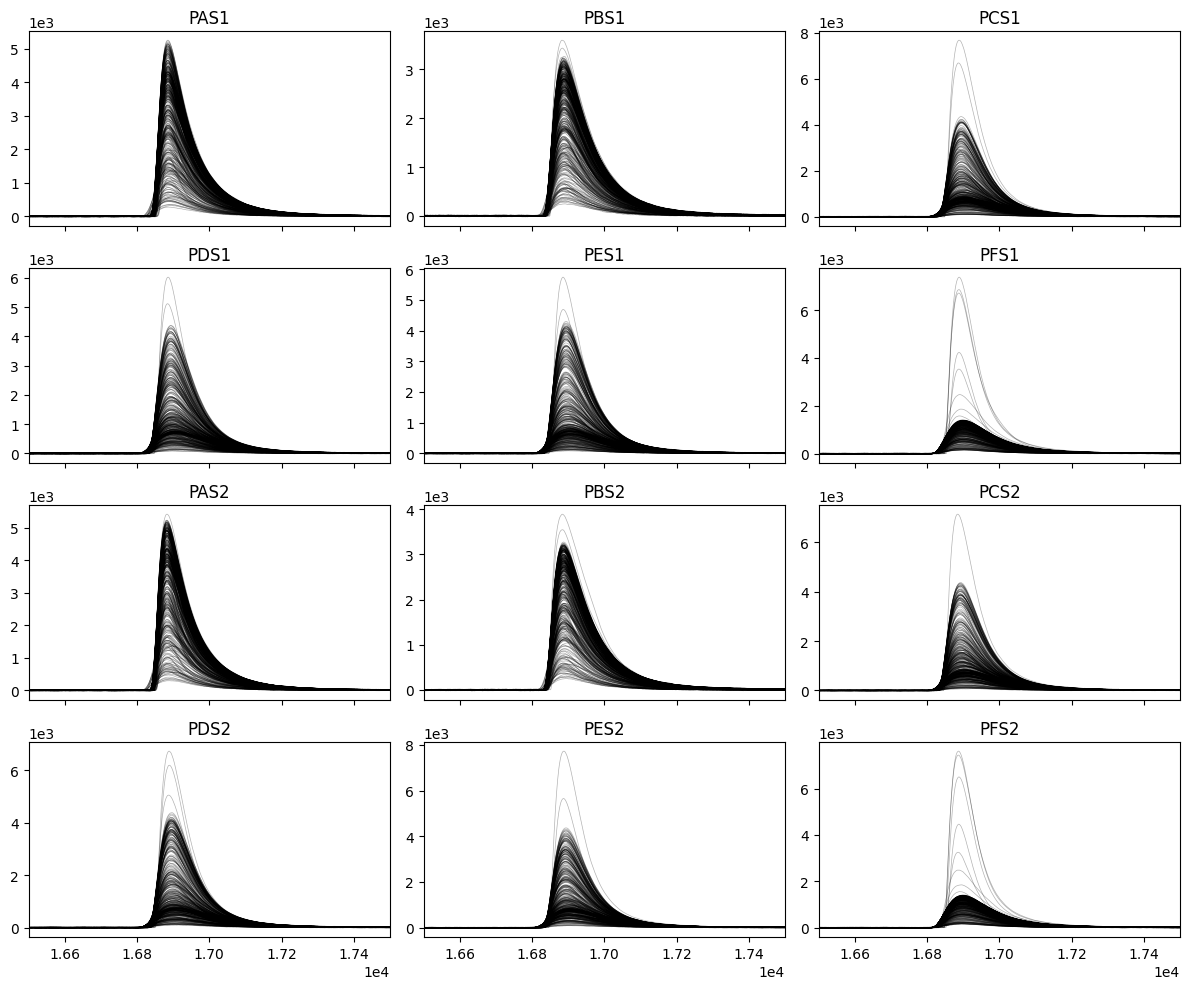

In [17]:
#det = 7
# get the average pulse aligned and normalized
sos = signal.butter(1, 10000, 'low', fs=samplerate, output='sos')
channel_set = {}
weird_series = {}
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(12, 10), sharex=True)
ax = ax.flatten()
chan_names = ['PAS1', 'PBS1', 'PCS1', 'PDS1', 'PES1', 'PFS1','PAS2', 'PBS2', 'PCS2', 'PDS2', 'PES2', 'PFS2']
for index, chan in enumerate(chan_names):
    series_trace = {}
    weird_series[chan] = {} 
    temp = []
    weird_series[chan]["51240909_000000"] = []
    numevents = events[det]["51240909_000000"]
    #if s in ws: continue
    for n in numevents:
        pulse = raw_events[det]["51240909_000000"][f'Z{det}'][chan][int("51240909_000000")][n][:]
        trace = pulse - baselines[det]["51240909_000000"][chan][n]
        # shift pulse to align the triggers
        aligned_trace = np.roll(trace, -round(delay[det]["51240909_000000"][chan][n]*625000))
        #if max(aligned_trace) < 0.4e3: #Z3 0.5e3 and Z6 0.4e3
        #    weird_series[chan][s].append(n)
        #    continue#print(s,max(aligned_trace))
        temp.append(aligned_trace)
        ax[index].plot(signal.sosfilt(sos, aligned_trace), alpha=0.3, color='black', linewidth=0.5)
    series_trace["51240909_000000"] = np.mean(temp,axis=0)/np.max(np.mean(temp,axis=0))
    ax[index].set_title(chan) 
    ax[index].set_xlim(16500,17500)
    ax[index].ticklabel_format(style="sci", scilimits=(0,0))
    channel_set[chan] = series_trace
    print(chan + " done")
plt.tight_layout()
plt.show()

### Fitting Average Channel Trace

/lscratch/yanliu/tmp/ipykernel_3589504/2473891966.py:9: RuntimeWarning: overflow encountered in exp
  y = np.where(x <= pretrigger, baseline, -((amp1+amp2) * np.exp(-(x-pretrigger) / t1 /samplerate) - amp1 * np.exp(-(x-pretrigger) / t2/samplerate) - amp2 * np.exp(-(x-pretrigger) / t3/samplerate)) + baseline)
/lscratch/yanliu/tmp/ipykernel_3589504/2473891966.py:9: RuntimeWarning: overflow encountered in multiply
  y = np.where(x <= pretrigger, baseline, -((amp1+amp2) * np.exp(-(x-pretrigger) / t1 /samplerate) - amp1 * np.exp(-(x-pretrigger) / t2/samplerate) - amp2 * np.exp(-(x-pretrigger) / t3/samplerate)) + baseline)
/lscratch/yanliu/tmp/ipykernel_3589504/2473891966.py:9: RuntimeWarning: invalid value encountered in subtract
  y = np.where(x <= pretrigger, baseline, -((amp1+amp2) * np.exp(-(x-pretrigger) / t1 /samplerate) - amp1 * np.exp(-(x-pretrigger) / t2/samplerate) - amp2 * np.exp(-(x-pretrigger) / t3/samplerate)) + baseline)


PAS1: 2.83e-05+-7.62e-08  7.73e-05+-6.30e-07  1.72e-04+-9.95e-07
PAS1: 1.71e+00   6.76e-012.64e-05  1.68424e+04
PBS1: 5.76e-05+-2.36e-05  5.83e-05+-2.43e-05  1.79e-04+-1.05e-06
PBS1: 1.60e+02   8.35e-011.63e-05  1.68357e+04
PCS1: 7.65e-05+-2.85e-05  7.68e-05+-2.87e-05  3.51e-04+-6.10e-06
PCS1: 5.24e+02   1.31e-01-2.58e-05  1.68335e+04
PDS1: 7.62e-05+-3.18e-05  7.65e-05+-3.20e-05  3.50e-04+-6.17e-06
PDS1: 5.32e+02   1.31e-016.09e-05  1.68323e+04
PES1: 7.64e-05+-3.58e-05  7.68e-05+-3.61e-05  3.44e-04+-6.11e-06
PES1: 4.85e+02   1.36e-011.15e-05  1.68331e+04
PFS1: 8.99e-05+-3.55e-05  9.03e-05+-3.57e-05  4.86e-04+-1.34e-05
PFS1: 5.68e+02   6.82e-02-1.68e-05  1.68273e+04
PAS2: 2.85e-05+-1.36e-07  1.52e-04+-5.13e-07  5.66e-05+-6.34e-07
PAS2: 9.42e-01   1.99e+003.16e-05  1.68417e+04
PBS2: 5.34e-05+-2.08e-05  5.42e-05+-2.15e-05  1.69e-04+-8.55e-07
PBS2: 1.26e+02   9.67e-013.03e-05  1.68365e+04
PCS2: 7.69e-05+-3.10e-05  7.73e-05+-3.12e-05  3.43e-04+-5.46e-06
PCS2: 5.37e+02   1.42e-016.51e-05  1.

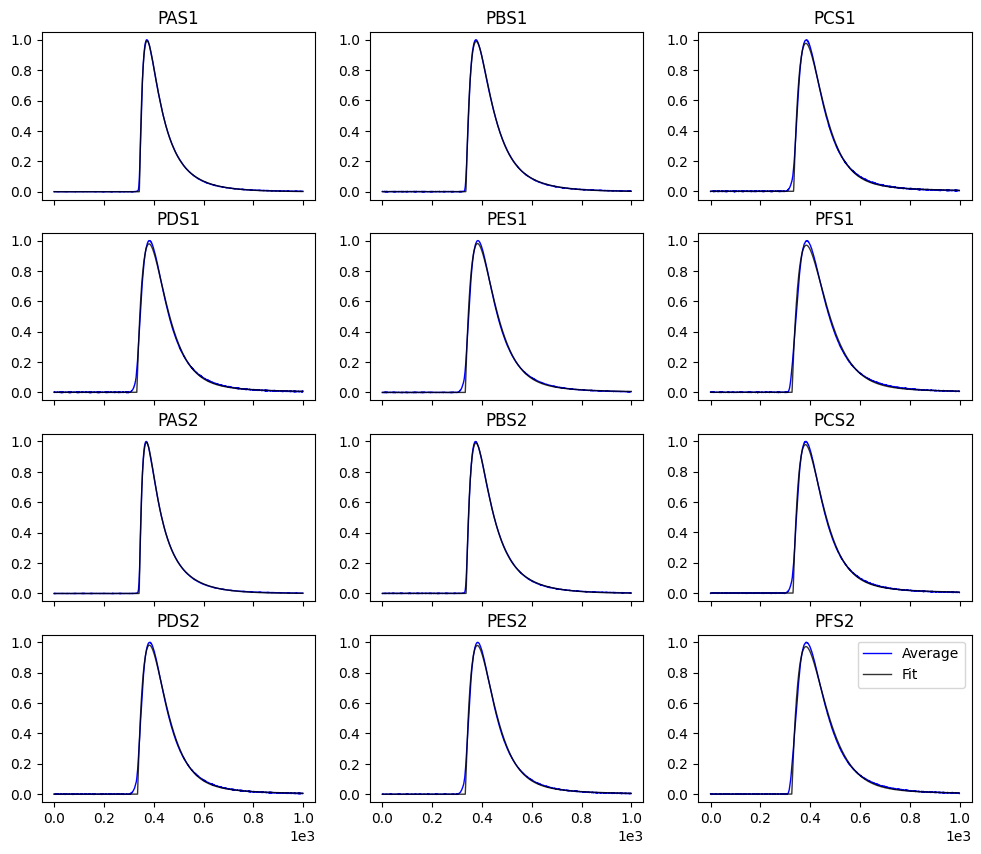

<Figure size 640x480 with 0 Axes>

In [18]:
# get the fits for the average trace

fit_avg_trace = {}
chan_names = ['PAS1', 'PBS1', 'PCS1', 'PDS1', 'PES1', 'PFS1','PAS2', 'PBS2', 'PCS2', 'PDS2', 'PES2', 'PFS2']
#chan_names = ['PAS1', 'PBS1']
average_trace = {}
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(12, 10), sharex=True)
ax = ax.flatten()
for index, chan in enumerate(chan_names):
    chan_trace = np.zeros(32768)
    chan_trace = (chan_trace + channel_set[chan]["51240909_000000"])
    #chan_trace /= len(series_list)
    chan_trace /= np.max(chan_trace)
    amp1_guess = 1
    amp2_guess = 1
    #t1_guess = 2e-4
    #t2_guess = 3e-4
    #t3_guess = 4e-4
    #t4_guess = 5e-4
    t1_guess = 7.7e-5
    t2_guess = 7.7e-4
    t3_guess = 2.8e-3
    bs_guess = 10
    pretrigger_guess = 16850
    popt, pcov = curve_fit(three_exp_fit, np.arange(len(chan_trace)), chan_trace, 
                           p0=[amp1_guess, amp2_guess, t1_guess, t2_guess, t3_guess, bs_guess, pretrigger_guess], maxfev=int(1e5))
    fit_avg_trace[chan] = three_exp_fit(np.arange(len(chan_trace)), *popt)
    average_trace[chan] = chan_trace
    ax[index].plot(average_trace[chan][16500:17500], label='Average', color='blue', linewidth=1, alpha=1)
    ax[index].plot(fit_avg_trace[chan][16500:17500], label='Fit', color='black', linewidth=1, alpha=0.8)
    ax[index].set_title(chan)
    ax[index].ticklabel_format(style="sci", scilimits=(0,0))
    print(chan + ': '+ f"{popt[2]:.2e}" + '+-' + f"{np.sqrt(pcov[2][2]):.2e} " + f" {popt[3]:.2e}" + '+-' + f"{np.sqrt(pcov[3][3]):.2e} " + f" {popt[4]:.2e}" + '+-' + f"{np.sqrt(pcov[4][4]):.2e}")
    print(chan + ': '+ f"{popt[0]:.2e}" + '   ' + f"{popt[1]:.2e}" + f"{popt[5]:.2e}" + '  ' + f"{popt[6]:.5e}")
plt.legend()
plt.show()
plt.tight_layout()

In [19]:
print(max(fit_avg_trace['PAS1']),max(average_trace['PAS1']), )#[max(channel_set['PFS2'][i]) for i in channel_set['PFS2'] ])

0.9926875600144363 1.0


In [20]:
# calculate pt
pt_fit = np.zeros(32768)
pt_avg = np.zeros(32768)
for chan in chan_names:
    #if chan == 'PAS1': continue
    pt_fit = pt_fit + fit_avg_trace[chan]
    pt_avg = pt_avg + average_trace[chan]
pt_fit /= len(chan_names)
pt_avg /= len(chan_names)
fit_avg_trace['PT'] = pt_fit/np.max(pt_fit) 
average_trace['PT'] = pt_avg/np.max(pt_avg)

/lscratch/yanliu/tmp/ipykernel_3589504/165331662.py:14: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


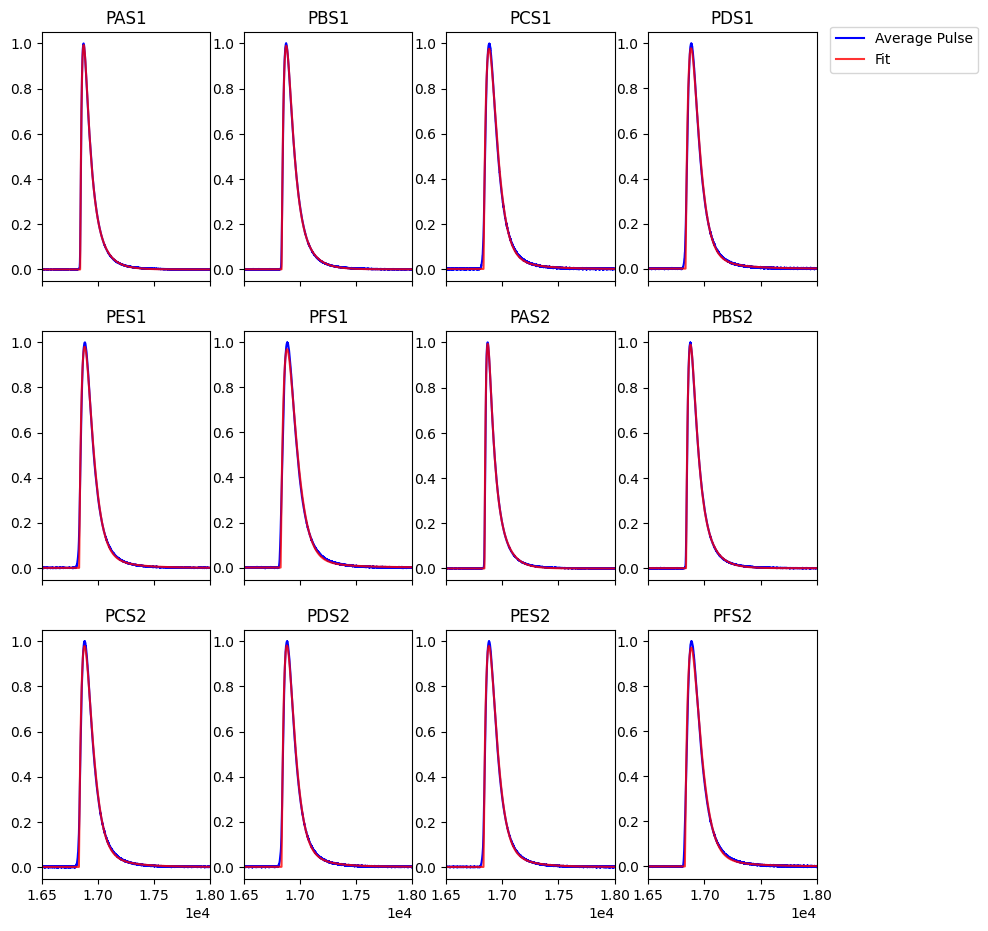

In [21]:
# plot the average pulse and the fit together
chan_names = ['PAS1', 'PBS1', 'PCS1', 'PDS1', 'PES1', 'PFS1','PAS2', 'PBS2', 'PCS2', 'PDS2', 'PES2', 'PFS2']

fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(10, 11), sharex=True)
ax = ax.flatten()
for index, chan in enumerate(chan_names):
    #if chan == "PAS1": continue
    ax[index].plot(average_trace[chan], label = 'Average Pulse', color='blue')
    ax[index].plot(fit_avg_trace[chan], label = 'Fit', color='red',alpha=0.8)
    ax[index].set_title(chan)
    ax[index].set_xlim(16500,18000)
    ax[index].ticklabel_format(style="sci", scilimits=(0,0))
plt.legend(bbox_to_anchor=(2.0,3.45))
plt.tight_layout()
plt.show()

### Writing 1x1 Templates to Root file

In [22]:
# write templates to a root file

# Create a new root file with the given name

file_name = "Templates_DC3ER_1x1_v1.root"
root_file = TFile(file_name, "RECREATE")

# Create a TDirectory in the root file
directory_name = f"zip{det}"
#directory = root_file.cd(directory_name)
directory = root_file.mkdir(directory_name).cd()
tracelength = 32768

# Generate some x values to plot the function
x = np.linspace(0, tracelength, tracelength)
# Compute the function values for the given parameters and x values

chan_names = ['PAS1', 'PBS1', 'PCS1', 'PDS1', 'PES1', 'PFS1','PAS2', 'PBS2', 'PCS2', 'PDS2', 'PES2', 'PFS2', 'PT', 'PS1', 'PS2']

trace = np.zeros(tracelength)

for chan in chan_names[:6]: 
    trace += fit_avg_trace[chan]
fit_avg_trace['PS1']=trace/np.max(trace)

trace = np.zeros(tracelength)
for chan in chan_names[6:12]: 
    trace += fit_avg_trace[chan]
fit_avg_trace['PS2']=trace/np.max(trace)

for channel in chan_names:
    # Create a TH1D with 32768 bins
    hist_name = channel
    hist_title = channel
    num_bins = tracelength
    x_min = 0
    x_max = tracelength
    histogram = TH1D(hist_name, hist_title, num_bins, x_min, x_max)
    
    # Fill the histogram with the scaled function values
    for i, value in enumerate(fit_avg_trace[channel]/np.max(fit_avg_trace[channel])):
        histogram.SetBinContent(i+1, value)

    # Write the histogram to the root file
    histogram.Write()

# Close the root file
root_file.Close()

### Checking Templates Against CMDSbats Templates

## NxM Templates

In [23]:
dets = [7]
chan_names = ['PAS1', 'PBS1', 'PCS1', 'PDS1', 'PES1', 'PFS1','PAS2', 'PBS2', 'PCS2', 'PDS2', 'PES2', 'PFS2']
chanSkip = {7:[]}
seriesSkip = {7:[]}

In [25]:
import pickle 
with open('cut_events1.pkl', 'rb') as file: 
    events = pickle.load(file)
with open('cut_raw_events1.pkl', 'rb') as file: 
    raw_events = pickle.load(file)
with open('cut_bs1.pkl', 'rb') as file: 
    baselines = pickle.load(file)
with open('cut_delay1.pkl', 'rb') as file: 
    delay = pickle.load(file)

PAS1 done
PBS1 done
PCS1 done
PDS1 done
PES1 done
PFS1 done
PAS2 done
PBS2 done
PCS2 done
PDS2 done
PES2 done
PFS2 done
Total events for Z7: 426


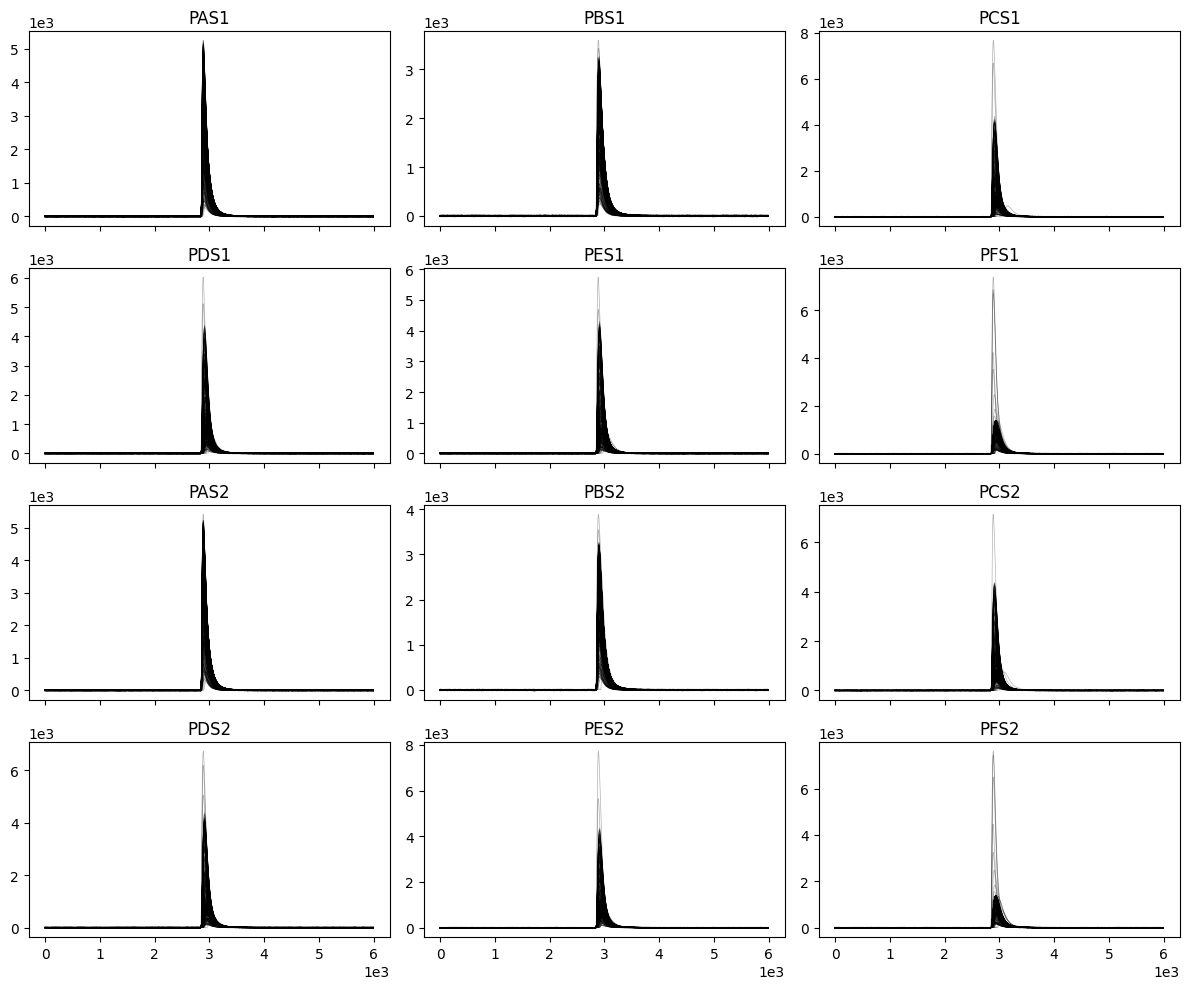

In [31]:
# get the average pulse aligned and normalized for NxM training
samplerate=625000
sos = signal.butter(1, 10000, 'low', fs=samplerate, output='sos')

training_set = {}

fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(12, 10), sharex=True)
ax = ax.flatten()
tot_nevt = 0
training_set[det] = {}

for index, chan in enumerate(chan_names):
    numevents = events[det]["51240909_000000"]
    if index == 0:
        tot_nevt += len(numevents)
    if chan in chanSkip[det]: continue
    for n in numevents:
        pulse = raw_events[det]["51240909_000000"][f'Z{det}'][chan][int("51240909_000000")][n][:]
        trace = signal.sosfilt(sos, pulse - baselines[det]["51240909_000000"][chan][n])

        # Trace alignment
        aligned_trace=0
        triggerindex= 16850 #Align at trigger index
        a=np.where(trace[:np.where(trace==max(trace))[0][0]]<0.005*max(trace))[0]
        if(len(a)!=0):
            startpulse=a[len(a)-1]
            if(startpulse>triggerindex):
                aligned_trace=np.append(trace[startpulse-triggerindex:],trace[:startpulse-triggerindex])
            else:
                aligned_trace=np.append(trace[len(trace)-triggerindex+startpulse:],trace[:len(trace)-triggerindex+startpulse])
            #print(np.argmax(aligned_trace))
        else:
            continue
                    
        cut_trace = aligned_trace[14000:20000]
        if np.argmax(cut_trace)<2250:
            print("BOOP! Misaligned trace detected!")
            continue
        if chan in training_set[det].keys():
            training_set[det][chan].append(cut_trace)
        else:
            training_set[det][chan] = [cut_trace]
        ax[index].plot(cut_trace, alpha=0.3, color='black', linewidth=0.5)
    ax[index].set_title(chan) 
    #ax[index].set_xlim(16000,17500)
    ax[index].ticklabel_format(style="sci", scilimits=(0,0))
    print(chan + " done")
print(f"Total events for Z{det}:",tot_nevt)
plt.tight_layout()
plt.show()

In [32]:
np.shape(training_set[7]['PBS1'][:150])

(150, 6000)

In [33]:
type(training_set[7]['PBS1'][1][1])

numpy.float64

In [34]:
training_set[7]['PAS1'][:3]

[array([-4.08792704, -4.65950311, -4.26625838, ...,  9.10608634,
         8.99490652,  8.12800608]),
 array([-0.89428666, -1.93190733, -3.20541509, ...,  6.86017271,
         6.99563083,  6.97441793]),
 array([-8.4471276 , -7.85444873, -7.51013918, ...,  0.12435778,
         0.71018861, -0.34074176])]

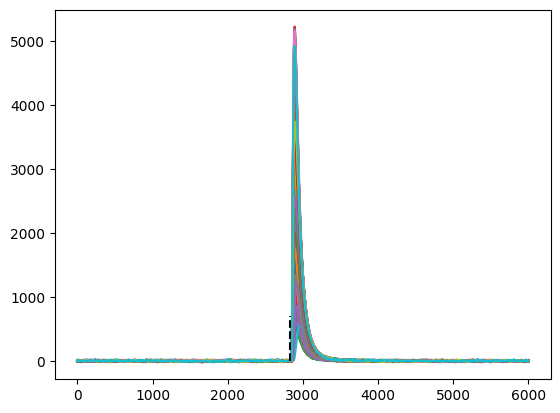

In [37]:
for i in range(len(training_set[7]['PAS1'][:150])):
    #if np.argmax(training_set[6]['PAS1'][i])<2250: continue
    plt.plot(training_set[7]['PAS1'][i],'-')
    #print(np.argmax(training_set[6]['PAS1'][i]))
#plt.plot(training_set[6]['PBS1'][1],'-')
plt.vlines(2830,0,700,linestyle='dashed',color='black')

In [38]:
from sklearn.decomposition import PCA

PCtot={}
perc_vartot={}
max_components=10
for d in dets:
    tempc={}
    var={}
    i=0
    for c in chan_names:
        if c not in chanSkip[d]:
            if(i==0):
                training = training_set[d][c][:150]
            else:
                training += training_set[d][c][:150]
            i+=1
    res = PCA(max_components,svd_solver='full').fit(training)

    PCtot[d] = res.components_
    perc_vartot[d] = res.explained_variance_ratio_

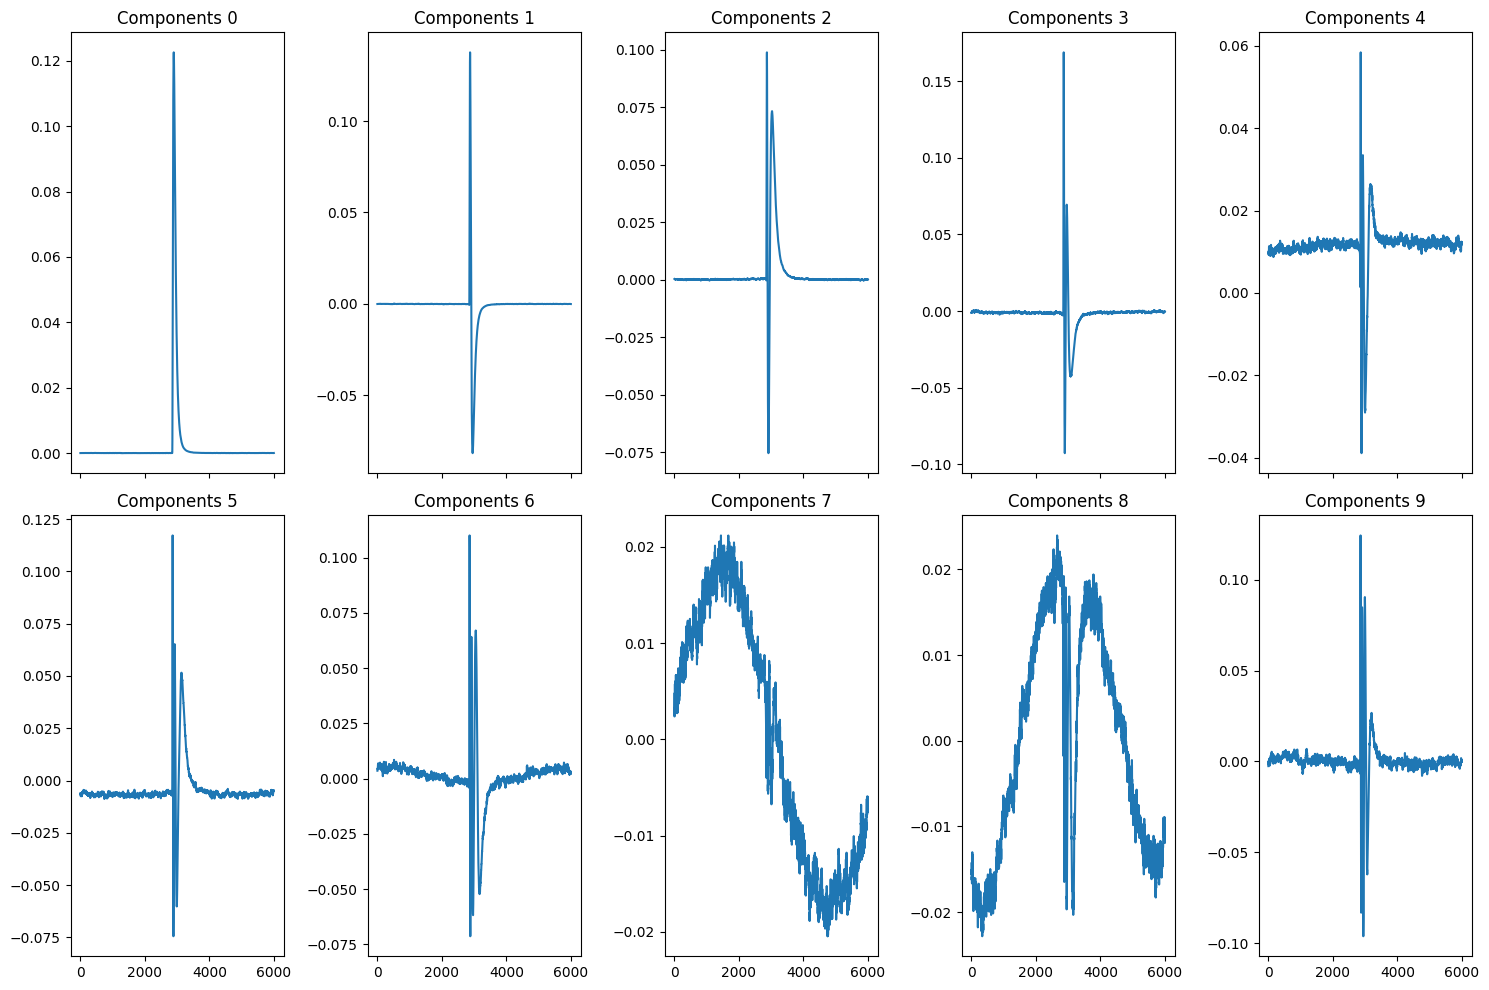

In [39]:
for det in dets:
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 10), sharex=True)
    ax = ax.flatten()
    for i,comp in enumerate(PCtot[det]):
        ax[i].plot(comp)
        ax[i].set_title(f"Components {i}")
    plt.tight_layout()
    plt.show()

Text(0.5, 0, 'Component')

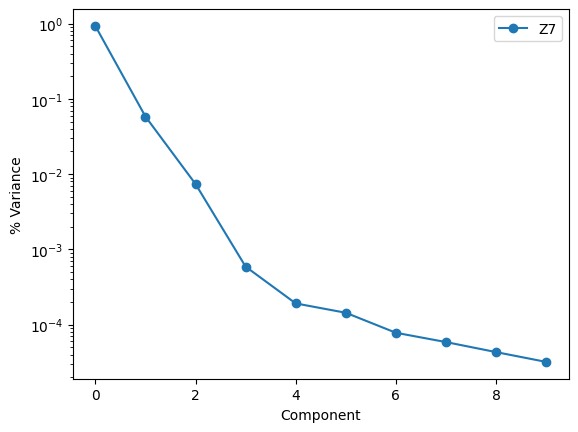

In [40]:
for det in dets:
    plt.plot(perc_vartot[det],'o-',label=f'Z{det}')
plt.legend()
plt.yscale('log')
plt.ylabel('% Variance')
plt.xlabel('Component')

### Removing Sine wave from component

In [42]:
def sine_func(x, A, B, C, D):
    return A * np.sin(B * x + C) + D
x_data = np.linspace(0, len(PCtot[7][3]), 6000)
# Fit the sine function to the data
popt, pcov = curve_fit(sine_func, x_data, PCtot[7][3], p0=[0.02, 1e-3, 0, 0.01])

In [43]:
popt

array([ 0.00207046,  0.00155005, -0.32515609, -0.00199721])

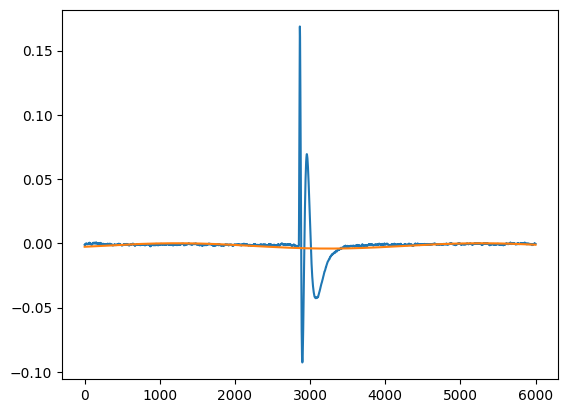

In [44]:
plt.plot(x_data,PCtot[7][3])
plt.plot(x_data, sine_func(x_data, *popt))

In [45]:
#remove sine wave
PCtot[7][3] = PCtot[7][3] - sine_func(x_data, *popt)

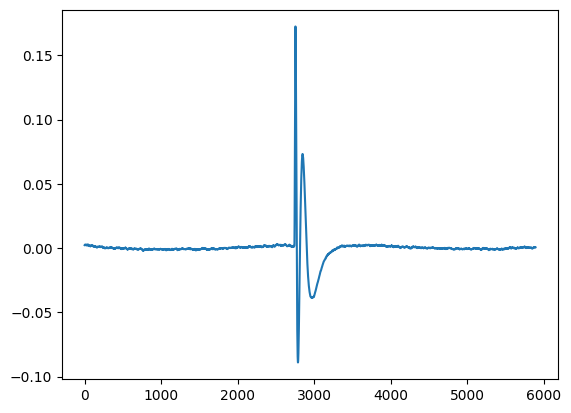

In [46]:
plt.plot(PCtot[7][3][110:]) # note the slice

In [47]:
#clipping first feature
PCtot[7][3] = np.insert(PCtot[7][3][110:],0,np.zeros(110))

6000


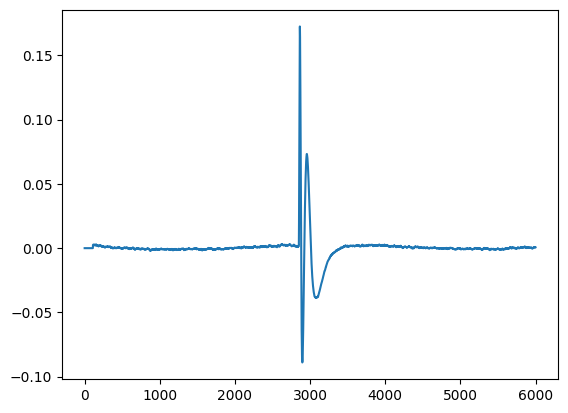

In [48]:
print(len(PCtot[7][3]))
plt.plot(PCtot[7][3])

### Writing NxM template to file

In [49]:
len(trace)

32768

In [50]:
padded = np.pad(PCtot[7][0], pad_width=(14000,0), mode='constant', constant_values=0)
padded = np.pad(padded, pad_width=(0,len(trace)-20000), mode='constant', constant_values=0)
len(padded)

32768

In [56]:
import ROOT
#rootfile = ROOT.TFile.Open("DC3ER_Templates_NxM_v1.root",'RECREATE')
rootfile = ROOT.TFile.Open("Templates_DC3ER_1x1_v1.root", 'UPDATE')
nBins=32768
#chanmap={"PFS1":"PAS1","PFS2":"PBS1"}
for det in dets:
    print(f"Detector Z{det}")
    rootfile.mkdir(f'zip{det}')
    rootfile.cd(f'zip{det}')
    for c in chan_names:
        if c in chanSkip[det]: continue
        print("Writing channel "+c)
        for i in range(4):
            print("Template {}".format(i+1))
            histname = c+'nxm'+str(i)
            hist=ROOT.TH1D(histname,histname,nBins,0,nBins)
            padded = np.pad(PCtot[det][i], pad_width=(14000,0), mode='constant', constant_values=0) # zeros at beginning
            padded = np.pad(padded, pad_width=(0,len(trace)-20000), mode='constant', constant_values=0) # zeros at end
            y = padded/max(padded)
            for j in range(1,nBins+1):
                #hist.SetBinContent(j,PC[c][i][j-1]/max(PC[c][i]))
                #hist.SetBinContent(j,Avg_PC[i][j-1]/max(Avg_PC[i]))
                hist.SetBinContent(j,y[j-1])
            hist.Write()
            hist.Delete()
rootfile.Close()

Detector Z7
Writing channel PAS1
Template 1
Template 2
Template 3
Template 4
Writing channel PBS1
Template 1
Template 2
Template 3
Template 4
Writing channel PCS1
Template 1
Template 2
Template 3
Template 4
Writing channel PDS1
Template 1
Template 2
Template 3
Template 4
Writing channel PES1
Template 1
Template 2
Template 3
Template 4
Writing channel PFS1
Template 1
Template 2
Template 3
Template 4
Writing channel PAS2
Template 1
Template 2
Template 3
Template 4
Writing channel PBS2
Template 1
Template 2
Template 3
Template 4
Writing channel PCS2
Template 1
Template 2
Template 3
Template 4
Writing channel PDS2
Template 1
Template 2
Template 3
Template 4
Writing channel PES2
Template 1
Template 2
Template 3
Template 4
Writing channel PFS2
Template 1
Template 2
Template 3
Template 4


Error in <TFile::mkdir>: An object with name zip7 exists already


In [57]:
import ROOT
#r = ROOT.TFile.Open("DC3ER_Templates_NxM_v1.root")
r = ROOT.TFile.Open("Templates_DC3ER_v1.root")


In [58]:
r.ls()

TFile**		Templates_DC3ER_v1.root	
 TFile*		Templates_DC3ER_v1.root	
  KEY: TDirectoryFile	zip7;1	zip7


In [59]:
h1_3 = r.Get('zip7/PBS1nxm0')
h3_3 = r.Get('zip7/PBS1nxm1')
h6_3 = r.Get('zip7/PBS1nxm2')

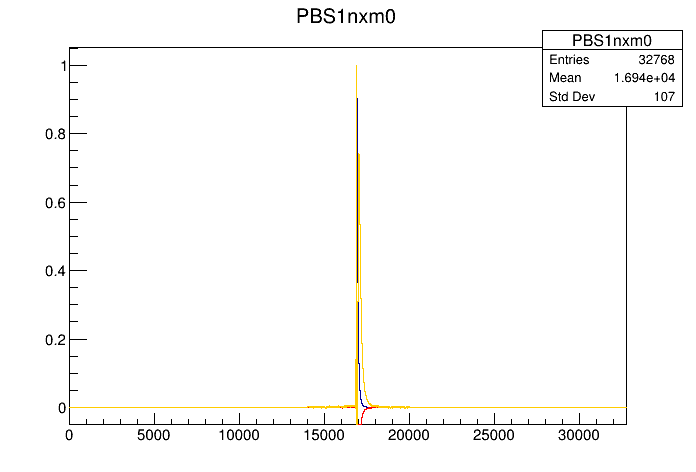

In [60]:
c =ROOT.TCanvas()
h1_3.Draw()
h3_3.SetLineColor(ROOT.kRed)
h3_3.Draw('same')
h6_3.SetLineColor(ROOT.kOrange)
h6_3.Draw('same')
c.Draw()